# Binning with uniform kernel

In [1]:
import numpy as np
import napari
import matplotlib.pyplot as plt
from skimage.io import imread # to load images from files
from scipy.ndimage import correlate, convolve
from readPTU_FLIM import PTUreader
from FLIM_phasor import *

### Creating a test image array

In [2]:
image_array = np.arange(120).reshape(5, 4, 6) # (signal_decay A * np.exp(-(1 / tau) * x), x-axis, y-axis)
print("Original Array:")
print(image_array)

Original Array:
[[[  0   1   2   3   4   5]
  [  6   7   8   9  10  11]
  [ 12  13  14  15  16  17]
  [ 18  19  20  21  22  23]]

 [[ 24  25  26  27  28  29]
  [ 30  31  32  33  34  35]
  [ 36  37  38  39  40  41]
  [ 42  43  44  45  46  47]]

 [[ 48  49  50  51  52  53]
  [ 54  55  56  57  58  59]
  [ 60  61  62  63  64  65]
  [ 66  67  68  69  70  71]]

 [[ 72  73  74  75  76  77]
  [ 78  79  80  81  82  83]
  [ 84  85  86  87  88  89]
  [ 90  91  92  93  94  95]]

 [[ 96  97  98  99 100 101]
  [102 103 104 105 106 107]
  [108 109 110 111 112 113]
  [114 115 116 117 118 119]]]


### Create function

In [3]:
def apply_conv_binning(flim_image, bin_size = 2):
    kernel=np.full((bin_size, bin_size), 1)

    image_binned = np.zeros_like(flim_image)
    for i in range(flim_image.shape[0]):
        image_binned[i, :, :] = convolve(flim_image[i, :, :],kernel)
    return(image_binned)
    

In [4]:
image_binned = apply_conv_binning(image_array, 3)

In [5]:
viewer = napari.Viewer()
original_layer = viewer.add_image(image_array)
binned_layer = viewer.add_image(image_binned)

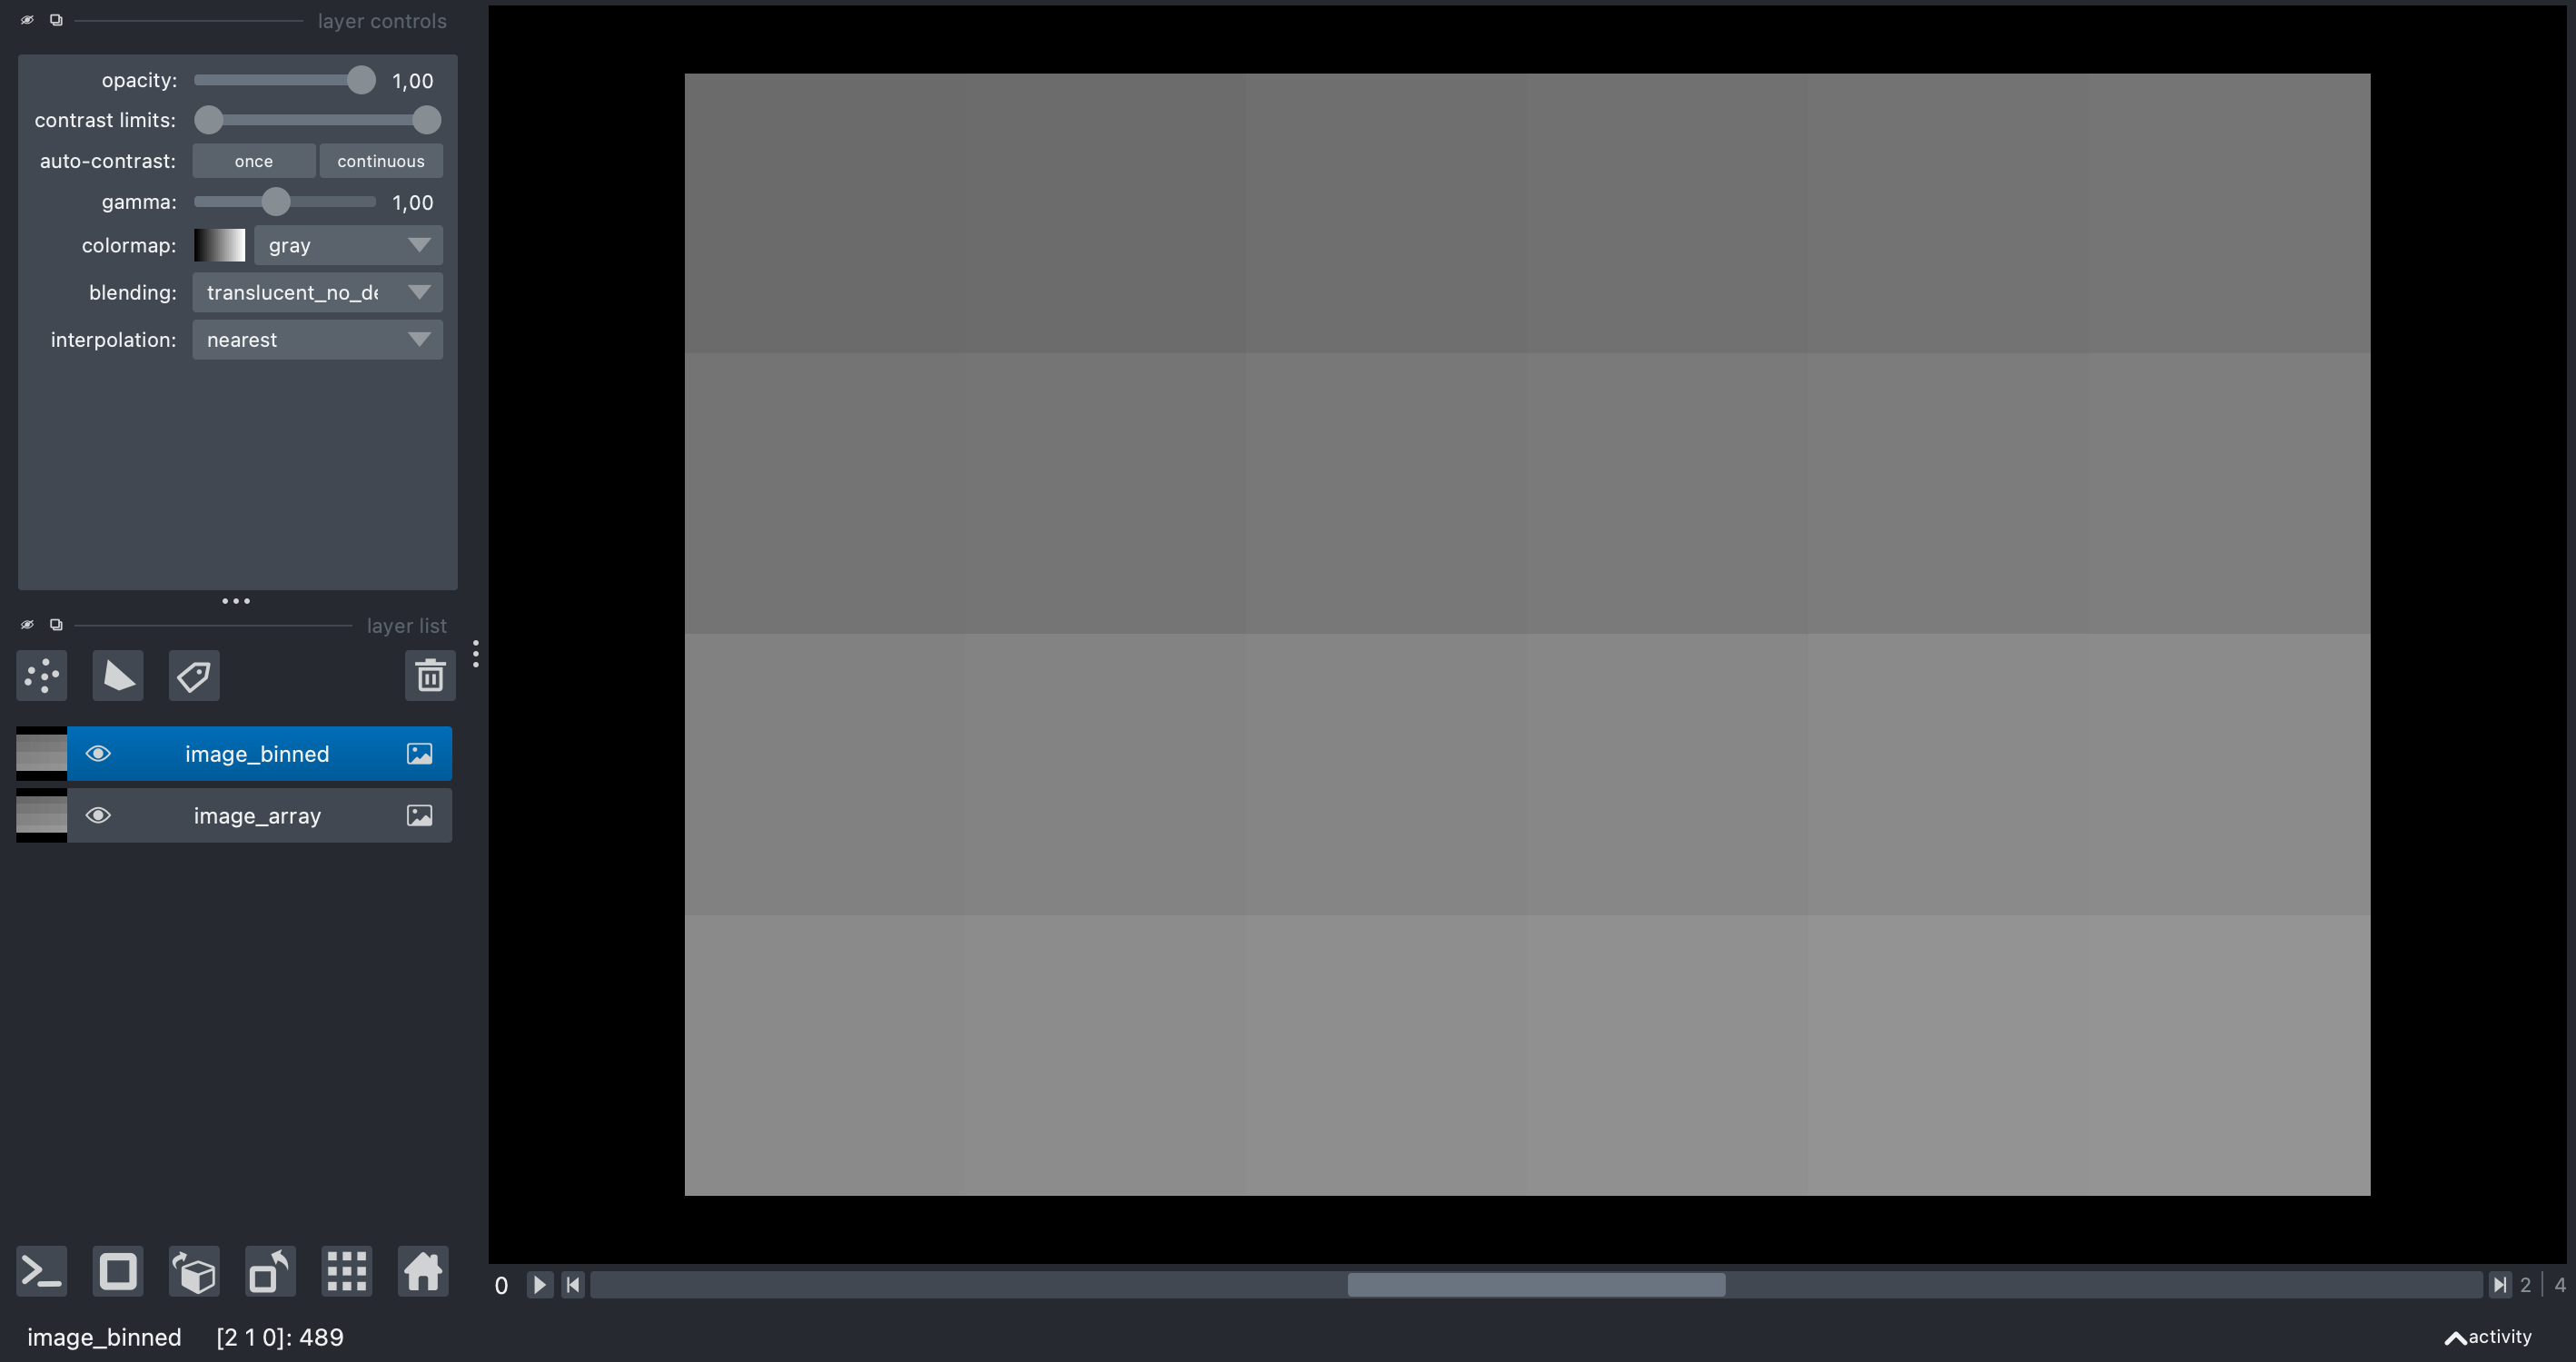

In [6]:
napari.utils.nbscreenshot(viewer)

## Using real data

In [7]:
data_path = "/Users/lana/Documents/PoLHiWi2023/Test_data/2a_FLIM_single_image.ptu"
ptu_file = PTUreader(data_path, print_header_data = False)
flim_data_stack, intensity_image = ptu_file.get_flim_data_stack()

flim_data_stack_for_napari = np.moveaxis(flim_data_stack, [0, 1], [-2, -1])

flim_data_stack_for_napari = flim_data_stack_for_napari[0, :, :, :]

TCSPC Hardware: PicoHarpT3
Raw Data has been Read!



In [8]:
laser_frequency = ptu_file.head['TTResult_SyncRate'] *1E-6 #MHz

In [9]:
time_array = create_time_array(laser_frequency, n_points = flim_data_stack_for_napari.shape[0])

In [10]:
flim_data_stack_for_napari.shape

(271, 512, 512)

In [11]:
viewer = napari.Viewer()
viewer.add_image(flim_data_stack_for_napari)

<Image layer 'flim_data_stack_for_napari' at 0x7f8ce565d3d0>

In [12]:
image_binned = apply_conv_binning(flim_data_stack_for_napari, 3)

In [13]:
viewer.add_image(image_binned)

<Image layer 'image_binned' at 0x7f8ce4b4fbe0>

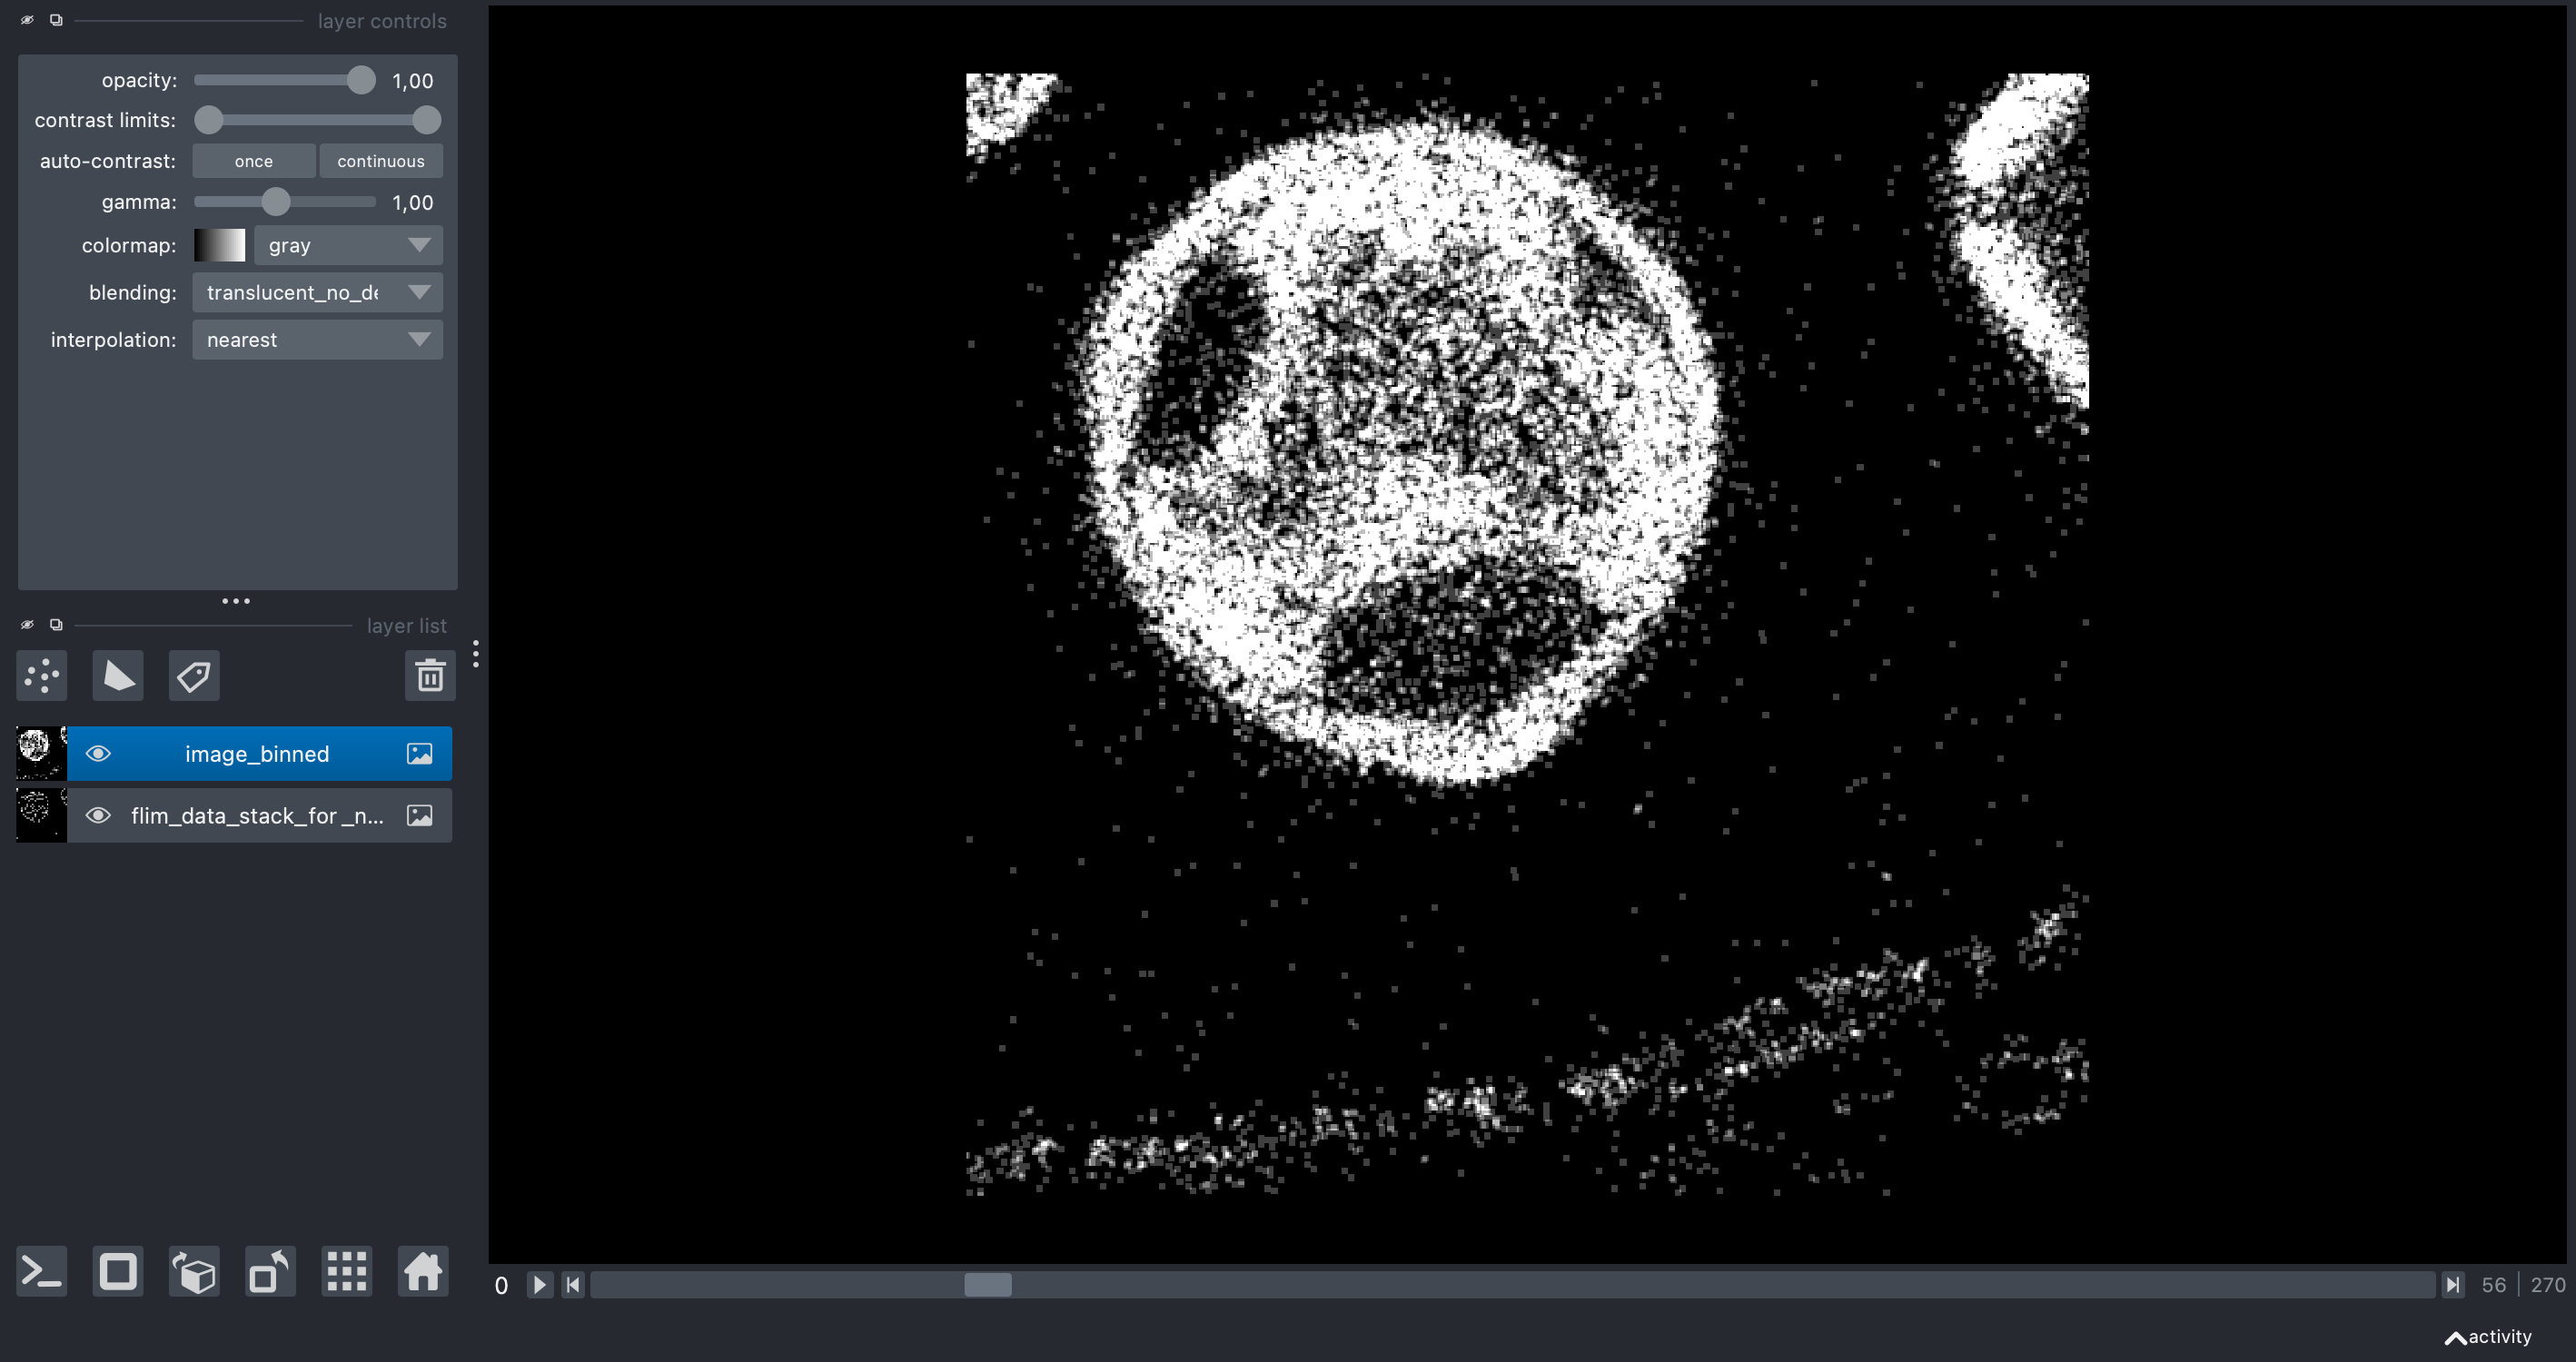

In [20]:
napari.utils.nbscreenshot(viewer)

## Comparing Phasor plots for binned and original image

In [15]:
threshold = 43

space_mask = intensity_image > threshold
threshold

43

In [16]:
time_array = create_time_array(laser_frequency, n_points = flim_data_stack_for_napari.shape[0])
time_step = time_array[1] # ns

heights, bin_edges = np.histogram(np.ravel(np.argmax(flim_data_stack_for_napari, axis=0) * time_step), bins=time_array)
start_index = np.argmax(heights[1:]) + 1
time_mask = time_array >= time_array[start_index]

In [17]:
number_of_harmonics = 2

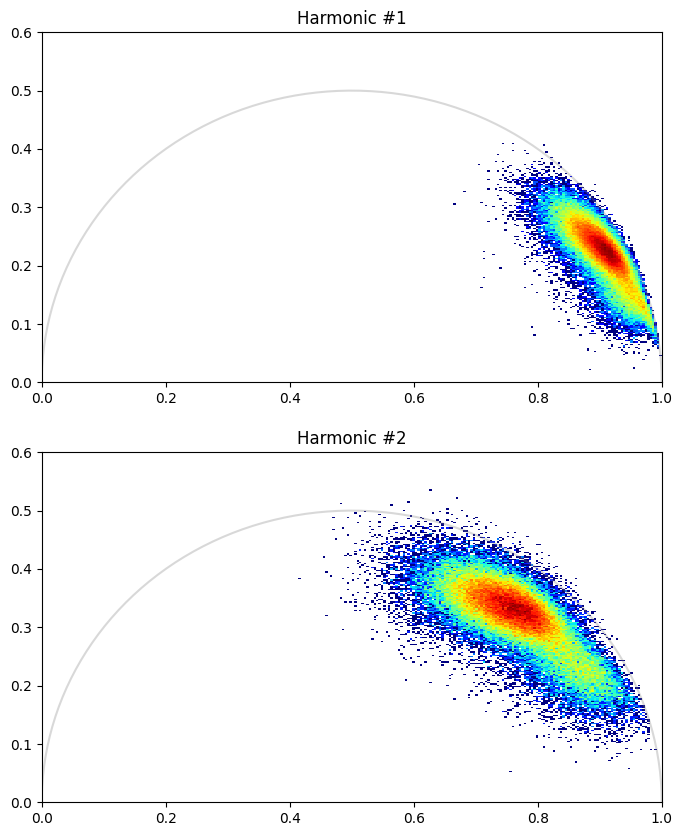

In [18]:
flim_image = flim_data_stack_for_napari
fig, ax = plt.subplots(number_of_harmonics, 1, figsize=(8, number_of_harmonics*5))
for i in range(number_of_harmonics):
    g, s, dc = get_phasor_components(flim_image[time_mask], harmonic = i+1)

    # Apply threshold
    x = np.ravel(g[space_mask])
    y = np.ravel(s[space_mask])
    
    if number_of_harmonics == 1:
        current_axis = ax
    else:
        current_axis = ax[i]
    
    add_phasor_circle(current_axis)
    #add_tau_lines(current_axis, tau_list, laser_frequency) 
    # current_axis.scatter(x,y, s=5, alpha=0.1, c='k')
    output = current_axis.hist2d(x, y, bins=256, norm='log', range=[[0, 1], [0, 0.6]], cmap = 'jet')
    title = 'Harmonic #' + str(i+1)
    current_axis.set_title(title)

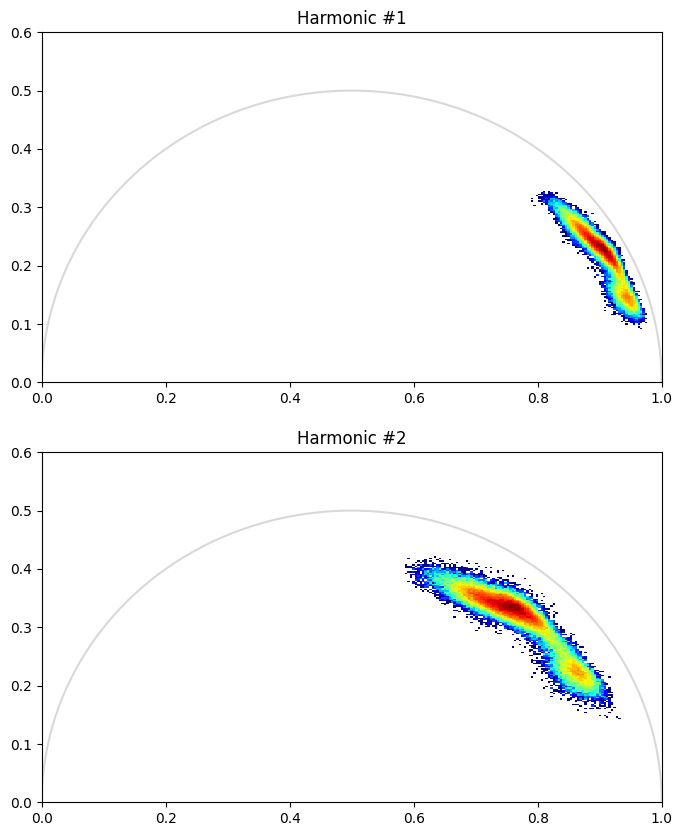

In [19]:
flim_image = image_binned
fig, ax = plt.subplots(number_of_harmonics, 1, figsize=(8, number_of_harmonics*5))
for i in range(number_of_harmonics):
    g, s, dc = get_phasor_components(flim_image[time_mask], harmonic = i+1)

    # Apply threshold
    x = np.ravel(g[space_mask])
    y = np.ravel(s[space_mask])
    
    if number_of_harmonics == 1:
        current_axis = ax
    else:
        current_axis = ax[i]
    
    add_phasor_circle(current_axis)
    #add_tau_lines(current_axis, tau_list, laser_frequency) 
    # current_axis.scatter(x,y, s=5, alpha=0.1, c='k')
    output = current_axis.hist2d(x, y, bins=256, norm='log', range=[[0, 1], [0, 0.6]], cmap = 'jet')
    title = 'Harmonic #' + str(i+1)
    current_axis.set_title(title)